In [347]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl

In [348]:
df = pd.read_csv('train.csv')
dt = pd.read_csv('test.csv')

In [349]:
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df['floor'] = df['Cabin'].str[0]

# Extrair apenas os números da cabine
# Remove todas as letras, mantém apenas números (pega o primeiro número se houver múltiplos)
df['Cabin'] = df['Cabin'].str.extract(r'(\d+)')[0]
#----------------------------------------------------------------------------------------------------------
dt['Sex'] = dt['Sex'].map({'male': 1, 'female': 0})
dt['Embarked'] = dt['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
dt['floor'] = dt['Cabin'].str[0]

# Extrair apenas os números da cabine
# Remove todas as letras, mantém apenas números (pega o primeiro número se houver múltiplos)
dt['Cabin'] = dt['Cabin'].str.extract(r'(\d+)')[0]

In [350]:
# # Verificar quantidade de NaN por coluna
# print("Valores NaN por coluna:")
# print(df.isnull().sum())
# print("\n% de NaN:")
# print((df.isnull().sum() / len(df) * 100).round(2))

In [351]:
# Tratamento de valores NaN

# 1. Age - Preencher com a mediana por sexo e classe
df['Age'] = df['Age'].fillna(df.groupby(['Sex', 'Pclass'])['Age'].transform('median'))

# 2. Embarked - Preencher com o valor mais comum (moda)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 3. Cabin/floor - Preencher com 'U' (Unknown) e 0 para números
df['floor'] = df['floor'].fillna('U')
df['Cabin'] = df['Cabin'].fillna(0)

# 4. Converter floor (letras) para números
df['floor'] = df['floor'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8, 'U': 0})

# 5. Converter Cabin para inteiro
df['Cabin'] = df['Cabin'].astype(int)
#----------------------------------------------------------------------------------------------------
dt['Age'] = dt['Age'].fillna(dt.groupby(['Sex', 'Pclass'])['Age'].transform('median'))

# 2. Embarked - Preencher com o valor mais comum (moda)
dt['Embarked'] = dt['Embarked'].fillna(dt['Embarked'].mode()[0])

# 3. Cabin/floor - Preencher com 'U' (Unknown) e 0 para números
dt['floor'] = dt['floor'].fillna('U')
dt['Cabin'] = dt['Cabin'].fillna(0)

# 4. Converter floor (letras) para números
dt['floor'] = dt['floor'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8, 'U': 0})

# 5. Converter Cabin para inteiro
dt['Cabin'] = dt['Cabin'].astype(int)

In [352]:
df = df.drop(columns=['PassengerId','Name','Ticket'])
x = df.drop(columns='Survived')
y = df['Survived']

# Dados de TESTE (test.csv - NÃO TEM Survived)
ids_test = dt['PassengerId']  # Salvar IDs para submissão
dt = dt.drop(columns=['PassengerId','Name','Ticket'])
print("Shape treino:", x.shape, y.shape)
print("Shape teste:", dt.shape)

Shape treino: (891, 9) (891,)
Shape teste: (418, 9)


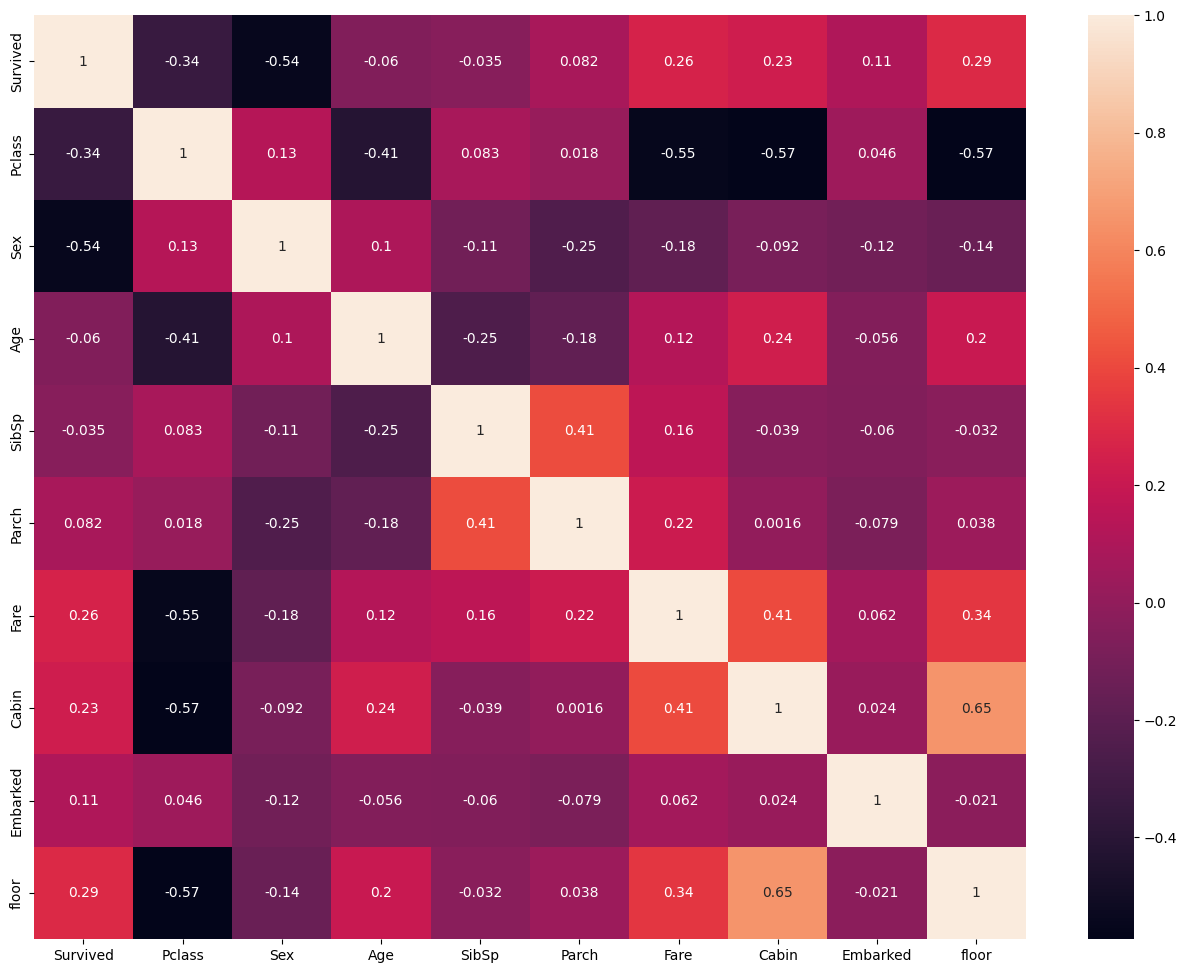

In [353]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

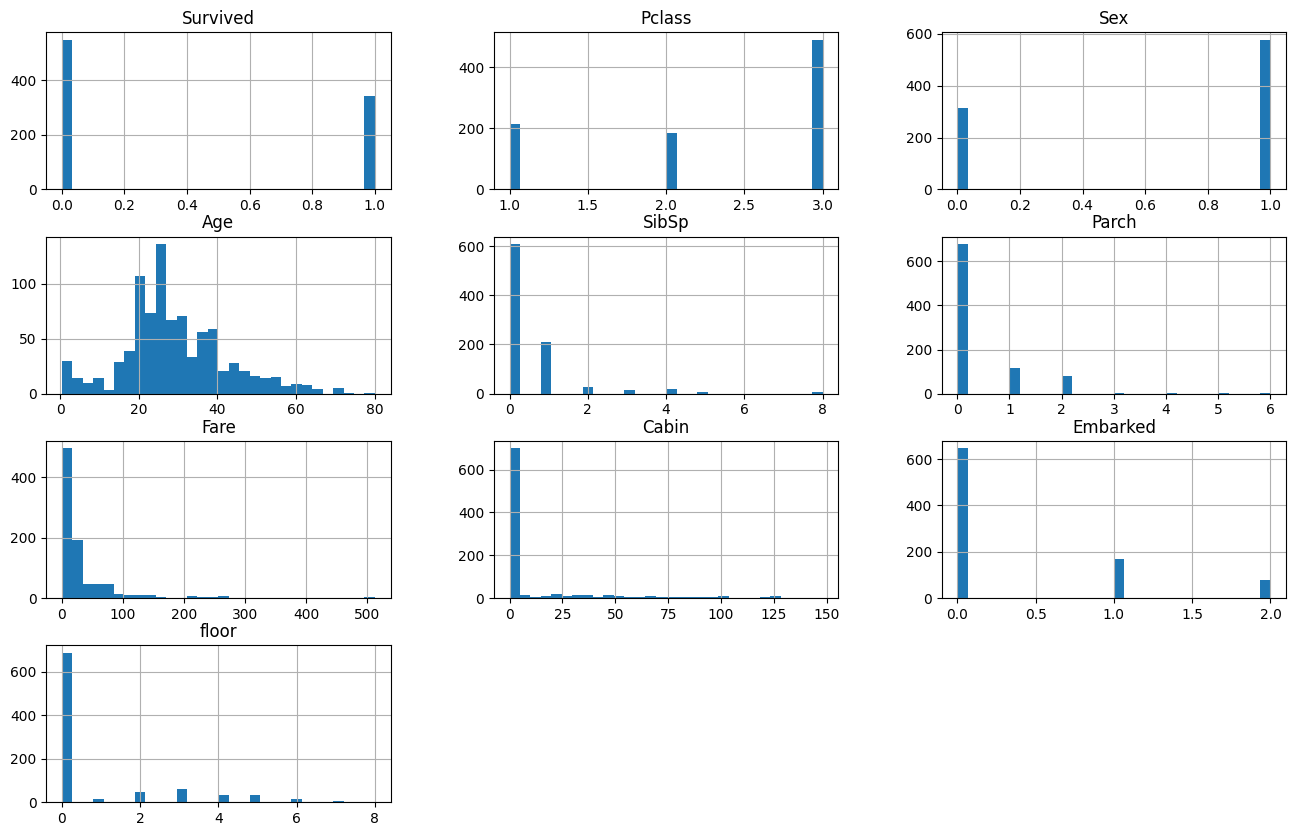

In [354]:
df.hist(bins=30, figsize=(16,10))
plt.show()

In [355]:
from sklearn.model_selection import train_test_split
# Adicionar random_state para reproduzir os mesmos resultados
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [356]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(objective ='binary:logistic', eval_metric = 'error', learning_rate = 0.1, max_depth = 4, n_estimators = 200)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [357]:
# Avaliar no treino (para ver overfitting)
result = xgb_classifier.score(X_test, y_test)
print("Accuracy no TREINO: {}".format(result))

# Fazer previsões no teste (não temos a resposta real)
predictions = xgb_classifier.predict(dt)

Accuracy no TREINO: 0.8324022346368715


In [358]:
# Classification report só funciona com dados que têm resposta (treino)
from sklearn.metrics import classification_report
y_predict_test = xgb_classifier.predict(X_test)
print(classification_report(y_test, y_predict_test))
# precision is the ratio of TP/(TP+FP)
# recall is the ratio of TP/(TP+FN)
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# where an F-beta score reaches its best value at 1 and worst score at 0.

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       105
           1       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



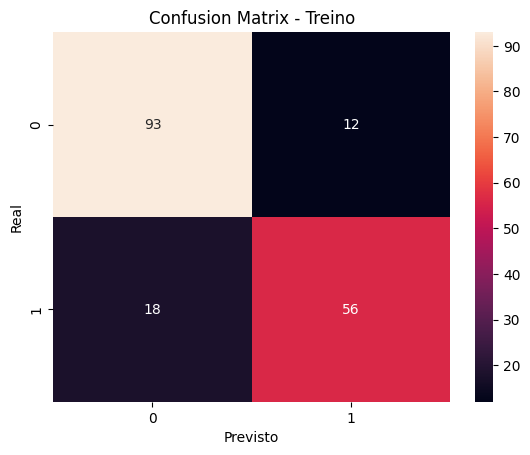

In [359]:
# Confusion matrix no treino
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, fmt='d', annot=True)
plt.title('Confusion Matrix - Treino')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

In [360]:
# Criar arquivo de submissão para o Kaggle
submission = pd.DataFrame({
    'PassengerId': ids_test,
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)
print("Arquivo submission.csv criado!")
print(submission.head(10))

Arquivo submission.csv criado!
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
